# Курсовой проект по теме "Видеокурс от Megafon"

### Описание задачи

В данном проекте перед нами стоит задача бинарной классификации.  
Нужно предсказать, согласится ли абонент на подключение услуги, если  
ему её предложить.  
Способом оценки качества модели, по условию задачи, будет метрика F1-score macro.  
В этом ноутбуке будут подробно описаны сделанные шаги, а также рассуждения по  
поводу выбора метрики и модели. После выполнения основной задачи классификации  
настроим модель с оглядкой на бизнес и напишем функцию, позволяющую использовать модель.

### Подключение библиотек

In [1]:
%matplotlib inline
from catboost import CatBoostClassifier
# from category_encoders import MEstimateEncoder
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

## 1. Загрузка данных

Столбец *id* будем преобразовывать в строковый тип данных, так как  
по умолчанию pandas преобразует его в числовой тип, и если некоторые значения  
признака имеют в начале строки '0', то они потеряют этот ноль.

#### 1.1 Датасет с признаками

In [2]:
%%time

df = pd.read_csv('features.csv', delim_whitespace=True, dtype={'id': str})

CPU times: total: 11min 36s
Wall time: 11min 36s


In [3]:
df.shape

(4512528, 255)

In [4]:
df.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


Имеем следующие признаки:  
- **id** - уникальный номер абонента.  
- **buy_time** - дата составления профиля абонента.  
- **остальные признаки** - анонимизированный набор признаков.

#### 1.2 Обучающий датасет

In [5]:
df_train = pd.read_csv('data_train.csv', index_col='Unnamed: 0', dtype={'id': str})
df_train.shape

(831653, 4)

In [6]:
df_train.head()

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0


Признаки:  
- **id** - то же, что в датасете с признаками.  
- **vas_id** - уникальный номер предлагаемой услуги.  
- **buy_time** - дата, когда была предложена услуга.  
- **target** - метка, где:  
1 - абонент согласился на подключение услуги;  
0 - абонент не согласился на подключение услуги.

#### 1.3 Тестовый датасет

In [7]:
df_test = pd.read_csv('data_test.csv', index_col='Unnamed: 0', dtype={'id': str})
df_test.shape

(71231, 3)

In [8]:
df_test.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


Признаки аналогичны обучающему датасету, отсутствует  
только *target*, который нам и нужно предсказать.

## 2. EDA <a class='anchor' id='edas'>

#### 2.1 Датасет с признаками

In [9]:
df.dtypes.value_counts()

float64    253
object       1
int64        1
dtype: int64

Все анонимизированные признаки являются вещественными.  

In [10]:
df.shape[0] - df['id'].nunique()

149789

Имеются дублированные значения уникальных id.

In [11]:
df[df.duplicated(['id', 'buy_time'], keep=False)].shape

(0, 255)

Нет ни одного повторения, где бы у нас совпадал уникальный id  
и дата создания профиля. Это говорит о том, что профиль клиента  
обновлялся со временем. Выведем список этих абонентов:

In [12]:
df[df.duplicated(['id'], keep=False)].sort_values('id')

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
2709826,1000,1544389200,-64.179971,-261.519112,-66.290786,-266.806798,-71.708246,-287.91179,16.53382,65.403903,...,-977.373846,-613.770792,-22.996269,-37.630448,-283.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1561535,1000,1546203600,-60.909971,-208.119112,-63.140786,-213.526798,-68.558246,-234.63179,16.05382,64.923903,...,-977.373846,-613.770792,-25.996269,-37.630448,-288.747724,-24.832889,-0.694428,-12.175933,-0.45614,0.0
794594,1000009,1542574800,-89.159971,-356.269112,-103.100786,-404.636798,-108.518246,-425.74179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,11.369552,-288.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
500359,1000009,1534712400,-14.989971,32.140888,-16.220786,-3.516798,-21.638246,-24.62179,-16.08618,-23.556097,...,-977.373846,-613.770792,-25.996269,-37.630448,-303.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2236836,1000016,1537736400,51.510029,36.750888,37.569214,70.583202,32.151754,49.47821,-16.08618,-65.076097,...,-976.373846,-613.770792,-25.996269,-37.630448,-220.747724,-2.832889,-0.694428,10.824067,-0.45614,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817063,999945,1542574800,-92.219971,-106.989112,-106.160786,-129.936798,-111.578246,-151.04179,-16.08618,-65.076097,...,-975.373846,-613.770792,-25.996269,-3.630448,-179.747724,-14.832889,-0.694428,-12.175933,-0.45614,0.0
183494,999956,1543179600,-51.379971,-233.959112,-65.320786,-286.566798,-70.738246,-307.67179,21.19382,79.383903,...,-977.373846,-613.770792,-25.996269,-32.630448,-298.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1717302,999956,1537736400,-68.839971,-247.119112,-82.780786,-283.616798,-88.198246,-304.72179,11.87382,60.763903,...,-977.373846,-613.770792,-25.996269,-37.630448,-290.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
1087142,99999,1539550800,25.350029,91.430888,11.409214,43.063202,5.991754,21.95821,7.64382,29.843903,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0


Действительно, некоторые признаки одних и тех же абонентов  
изменялись со временем.  
Посмотрим на наличие пропущенных значений в датасете:

In [13]:
df.isna().sum().sum()

0

Пропущенных значений нет.

In [14]:
df['buy_time'].apply(lambda x: datetime.datetime.fromtimestamp(x)).describe(datetime_is_numeric=True)

count                          4512528
mean     2018-10-15 12:03:06.373934080
min                2018-07-09 00:00:00
25%                2018-08-20 00:00:00
50%                2018-10-15 00:00:00
75%                2018-12-17 00:00:00
max                2019-01-21 00:00:00
Name: buy_time, dtype: object

Имеем значения дат создания профиля абонента от июля 2018г.  
до января 2019г.

#### 2.2 Обучающий датасет

In [15]:
df_train['target'].value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

Датасет имеет очень большой дисбаланс классов.

In [16]:
df_train.shape[0] - df_train['id'].nunique()

25040

Есть повторения среди абонентов.

In [17]:
df_train[df_train.duplicated(['id', 'vas_id'], keep=False)].shape[0]

12498

Некоторым абонентам одна и та же услуга предлагалась более одного раза.

In [18]:
df_train[df_train.duplicated(['id', 'vas_id', 'buy_time'], keep=False)].shape[0]

0

Полных дубликатов датасет не имеет.

In [19]:
df_train.isna().sum().sum()

0

Пропущенных значений нет.

In [20]:
df_train['vas_id'].value_counts()

1.0    310175
2.0    249505
5.0     94085
4.0     85756
6.0     57878
7.0     15432
8.0     13350
9.0      5472
Name: vas_id, dtype: int64

Всего у нас 8 различных предлагаемых абонентам услуг.

In [21]:
df_train['buy_time'].apply(lambda x: datetime.datetime.fromtimestamp(x)).describe(datetime_is_numeric=True)

count                           831653
mean     2018-10-07 21:23:38.779707904
min                2018-07-09 00:00:00
25%                2018-08-13 00:00:00
50%                2018-10-01 00:00:00
75%                2018-12-10 00:00:00
max                2018-12-31 00:00:00
Name: buy_time, dtype: object

В обучающем датасете услуги предлагались абонентам  
с июля 2018г. по декабрь 2018г.

#### 2.3 Тестовый датасет

In [22]:
df_test.shape[0] - df_test['id'].nunique()

1079

In [23]:
df_test[df_test.duplicated(['id', 'vas_id'], keep=False)].shape[0]

184

In [24]:
df_test[df_test.duplicated(['id', 'vas_id', 'buy_time'], keep=False)].shape[0]

0

In [25]:
df_test.isna().sum().sum()

0

По дубликатам и пропущенным значениям всё аналогично  
обучающему датасету.

In [26]:
df_test['buy_time'].apply(lambda x: datetime.datetime.fromtimestamp(x)).describe(datetime_is_numeric=True)

count                            71231
mean     2019-01-12 20:42:25.790456320
min                2019-01-07 00:00:00
25%                2019-01-07 00:00:00
50%                2019-01-14 00:00:00
75%                2019-01-14 00:00:00
max                2019-01-21 00:00:00
Name: buy_time, dtype: object

В тестовом датасете услуги предлагались абонентам  
только в январе 2019г.

Из предварительного ознакомления с датасетами можно  
сделать вывод, что не все строки датасета с признаками  
нам нужны для непосредственного соединения с обучающим  
и тестовым датасетами, так как число абонентов в них  
значительно меньше. Отсюда, есть потенциал для сокращения  
размера исходного большого датасета в случае, к примеру,  
нехватки оперативной памяти для его хранения.  
В нашем случае оставим датасет как есть, так как в дальнейшем  
нам пригодятся дополнительные строки для более точного  
установления распределений признаков в целях обработки  
выбросов, и т.к. размер исходного датасета не является проблемой.

## 3. Обучение baseline модели <a class='anchor' id='baseline'>

Для подготовки полноценного обучающего датасета соединим  
наш обучающий датасет с датасетом признаков по уникальному  
номеру абонента:

In [27]:
df_train = df_train.merge(df, how='left', on='id')

In [28]:
df_train.head()

,id,vas_id,buy_time_x,target,buy_time_y,0,1,2,3,4,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,1541970000,-31.559971,327.360888,-45.500786,274.753202,-50.918246,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,1531083600,547.270029,238.430888,533.329214,274.803202,527.911754,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,1534107600,0.0,1543179600,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,1535922000,0.0,1533502800,54.880029,12.970888,54.079214,-9.116798,48.661754,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,1535922000,0.0,1543179600,45.160029,295.240888,64.679214,344.283202,59.261754,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [29]:
df_train.shape

(860052, 258)

Размер датасета увеличился за счёт дублированных номеров абонентов  
из датасета с признаками.  

Зададим величину random_state для воспроизводимости результатов:

In [30]:
RANDOM_STATE = 29

Разделим на train и test:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['target', 'id'], axis=1), df_train['target'],
                                                    test_size=0.3, random_state=RANDOM_STATE)

Убедимся, что выборки получились неплохо стратифицированными:

In [32]:
y_train.value_counts(normalize=True)

0.0    0.927474
1.0    0.072526
Name: target, dtype: float64

In [33]:
y_test.value_counts(normalize=True)

0.0    0.928128
1.0    0.071872
Name: target, dtype: float64

В качестве baseline модели выберем логистическую регрессию за её простоту.  
Перед обучением модели будем масштабировать данные, т.к. линейные модели  
могут неправильно выявлять закономерности в данных, если они не масштабированы.

In [34]:
baseline_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=500))
])

Обучим модель и сделаем предсказание вероятности отнесения  
к 1-му классу:

In [35]:
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(max_iter=500))])

In [36]:
y_pred = baseline_model.predict_proba(X_test)[:, 1]

Напишем функцию для поиска оптимального порога классификации.  
Поиск будет производиться с учётом максимизации F1-score 1-го  
класса. При имеющемся дисбалансе классов именно метрика 1-го  
класса будет сильнее реагировать на изменение порога классификации,  
что, в свою очередь, будет оказывать влияние на F1-score macro:

In [37]:
def find_best_threshold(y_test, y_pred, verbose=True):

    # Находим значения составляющих F-score метрик и порогов,
    # при которых эти значения получены
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

    # Рассчитываем F1-score 1-го класса для каждого значения порога
    fscore = (2 * precision * recall) / np.clip((precision + recall), a_min=1e-4, a_max=np.inf)
    
    # Находим индекс, при котором имеем максимальный F1-score
    idx = np.argmax(fscore)
              
    if verbose:
        print(f'Best Threshold={thresholds[idx]}')
    
    # Возвращаем значение порога, при котором получили максимальный F1-score
    return thresholds[idx]

Рассчитаем порог классификации для baseline модели:

In [38]:
baseline_threshold = find_best_threshold(y_test, y_pred)

Best Threshold=0.2009788465918036


Выведем значения основных метрик baseline модели:

In [39]:
print(classification_report(y_test, y_pred >= baseline_threshold))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94    239472
         1.0       0.29      0.38      0.33     18544

    accuracy                           0.89    258016
   macro avg       0.62      0.65      0.63    258016
weighted avg       0.90      0.89      0.90    258016



Посмотрим на признаки, которые baseline модель посчитала наиболее важными:

In [40]:
features = pd.DataFrame(baseline_model['classifier'].coef_.reshape(-1, 1), 
                        X_train.columns, 
                        columns=['coefficient'])

features.sort_values('coefficient', ascending=False).head(10)

,coefficient
vas_id,0.768880
buy_time_x,0.410939
45,0.316268
162,0.235124
209,0.176331
43,0.174638
123,0.143851
14,0.112211
50,0.096607
116,0.073154


Наиболее важный признак для модели - предлагаемая абоненту услуга.

## 4. Обработка выбросов <a class='anchor' id='outliers'>

В целях исключения возможных выбросов в скоплении анонимизированных  
вещественных признаков, будем отсеивать значения, которые выходят за  
рамки полутора интерквартильных размахов. Для этого напишем функцию:

In [41]:
def process_outliers(df, column):
    
    # Найдём первый и третий квартили
    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    
    # Интерквартильный размах - это разница между ними
    iqr = q75 - q25
    
    # Посчитаем верхнюю и нижнюю границы, значения за
    # пределами которых будем считать выбросами
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr
    
    # Выбросы будем заменять на моду, так как многие признаки
    # имеют подавляющее большинство какого-то одного значения
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = df[column].value_counts().index[0]

Возьмём произвольно три признака и убедимся в правильности наших  
суждений о преобладающем значении в признаках:

In [42]:
np.random.seed(0)

In [43]:
df[f'{np.random.randint(0, 250)}'].value_counts().head()

-30.821719    1083377
-30.571719       5022
-30.588386       4777
-30.521719       4770
-30.655052       4671
Name: 172, dtype: int64

In [44]:
df[f'{np.random.randint(0, 250)}'].value_counts().head()

-7.997875    2364084
-7.397875         98
-6.797875         74
-7.697875         66
-7.797875         64
Name: 47, dtype: int64

In [45]:
df[f'{np.random.randint(0, 250)}'].value_counts().head()

-2298.725139    1471676
-2298.724162       6003
-2298.722209       1817
-2298.723185       1794
-2298.723186       1741
Name: 117, dtype: int64

Запустим обработку вещественных признаков:

In [46]:
for column in df.columns:
    if column not in ['id', 'buy_time']:
        process_outliers(df, column)

## 5. Определение типов признаков <a class='anchor' id='types'>

Для уточнения типов признаков найдём количество их уникальных значений:

In [47]:
X_nunique = df.drop(['id', 'buy_time'], axis=1).apply(lambda x: x.nunique())

Построим график распределения:

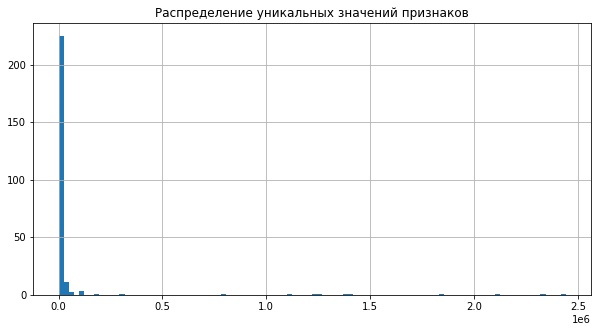

In [48]:
plt.title('Распределение уникальных значений признаков')
X_nunique.hist(bins=100, figsize=(10, 5))
plt.show()

Из графика можно сделать вывод, что подавляющее большинство признаков  
имеют относительно малое количество уникальных значений. Собственно,  
выше мы в этом косвенно убедились, когда смотрели на значения случайно  
выбранных признаков.  
Далее разобъём признаки на категории для дальнейшей индивидуальной  
работы с ними.

Всего числовых признаков:

In [49]:
f_all = set(X_nunique.index.tolist())
len(f_all)

253

#### 5.1 Константные признаки

In [50]:
f_const = set(X_nunique[X_nunique == 1].index.tolist())
len(f_const)

146

Более половины признаков после обработки выбросов имеют всего  
одно значение. В обучении их использовать не будем.

In [51]:
f_other = f_all - f_const

#### 5.2 Бинарные признаки

In [52]:
f_binary = set(X_nunique[X_nunique == 2].index.tolist())
len(f_binary)

6

In [53]:
f_other = f_other - f_binary

#### 5.3 Категориальные признаки

За категориальные признаки возьмём те, которые имеют  
не более 20 уникальных значений, также сюда войдёт признак *vas_id*:

In [54]:
f_categorical = set(X_nunique.loc[list(f_other)][X_nunique[list(f_other)] <= 20].index.tolist())
f_categorical.add('vas_id')
len(f_categorical)

23

#### 5.4 Вещественные признаки

Все остальные признаки будем считать вещественными.    
Даты составления профиля абонента и предложения услуги  
не будем включать в обучение, по ним будет только разбивка  
и склеивание датасетов.

In [55]:
f_numeric = f_other - f_categorical

Имеем следующую картину:

In [56]:
print(f'f_const:\t{len(f_const)}\n'
      f'f_binary:\t{len(f_binary)}\n'
      f'f_categorical:\t{len(f_categorical)}\n'
      f'f_numeric:\t{len(f_numeric)}')

f_const:	146
f_binary:	6
f_categorical:	23
f_numeric:	79


Число признаков, по которым будем обучаться:

In [57]:
len(f_binary) + len(f_categorical) + len(f_numeric)

108

## 6. Выбор модели

Напишем функцию для объединения датасетов.  
Из датасета с признаками, в случае дубликатов,  
будем брать ту строку, которая ближе всего  
по дате создания профиля абонента к дате предложения  
услуги абоненту.

In [58]:
def merge_datasets(df_features, df_labels):
    df_labels = df_labels.merge(df_features, how='left', on='id')
    df_labels['diff'] = np.abs(df_labels['buy_time_x'] - df_labels['buy_time_y'])
    return df_labels.sort_values('diff').drop_duplicates(['id', 'vas_id', 'buy_time_x'])

Напишем свой класс для пайплайнов, который выбирает  
признаки по нашим категориям. Изначально была попытка провести  
target-encoding признака *vas_id*, так как он категориальный,  
и при обработке его аналогично другим категориальным признакам  
(one-hot-encoding), некоторые его значения получали низкую важность  
у моделей. Но по целевой метрике это оказалось менее эффективно,  
и, в итоге, было принято решение оставить one-hot-encoding.  
Использовавшийся ранее код закомментирован.

In [59]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

# class TargetEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.encoder = None
        
#     def fit(self, X, y):
        
#         # Берем подвыборку размером 20% от обучающего датасета
#         # для снижения возможного переобучения
#         X_encode = X.sample(frac=0.2, random_state=RANDOM_STATE)
#         y_encode = y[X_encode.index]
#         self.encoder = MEstimateEncoder(cols=X.columns)
#         self.encoder.fit(X_encode, y_encode)
#         return self
    
#     def transform(self, X):
#         return self.encoder.transform(X)

Определим пайплайны:

In [60]:
# Бинарные признаки отмасштабируем, т.к. не все из них
# имеют значения 0 и 1
binary_features = Pipeline([
    ('selector', ColumnSelector(columns=list(f_binary))),
    ('scaler', StandardScaler())
])

# Категориальные признаки подвергнем ohe-hot-encoding'у
cat_features = Pipeline([
    ('selector', ColumnSelector(columns=list(f_categorical))),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Вещественные признаки отмасштабируем
numeric_features = Pipeline([
    ('selector', ColumnSelector(columns=list(f_numeric))),
    ('scaler', StandardScaler())
])

# # Сделаем target-encoding признака vas_id
# vas_id_feature = Pipeline([
#     ('selector', ColumnSelector(columns=['vas_id'])),
#     ('encoder', TargetEncoder())
# ])

# Соберем все признаки при помощи Feature Union
feats = FeatureUnion([
    ('binary', binary_features),
    ('categorical', cat_features),
    ('numeric', numeric_features),
    # ('vas_id', vas_id_feature)
])

Загрузим обучающий датасет заново, т.к. ранее  
мы присоединяли к нему еще не обработанные от  
выбросов признаки:

In [61]:
df_train = pd.read_csv('data_train.csv', index_col='Unnamed: 0', dtype={'id': str})

Высчитаем дисбаланс классов для использования его при обучении  
моделей, в которых его нужно явно задавать:

In [62]:
disbalance = (df_train['target'] == 0).sum() / (df_train['target'] == 1).sum()

Определим модели. Зададим стандартный набор параметров,  
главной задачей сейчас является выбор оптимальной модели:

In [63]:
rf_model = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))
])

cb_model = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(iterations=200, silent=True,
                                      eta=0.1, task_type='GPU',
                                      auto_class_weights='Balanced', random_state=RANDOM_STATE))
])

xgb_model = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(n_estimators=200,
                                 eta=0.1, tree_method='gpu_hist',
                                 scale_pos_weight=disbalance,
                                 predictor='gpu_predictor',
                                 random_state=RANDOM_STATE))
])

lr_model = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(max_iter=500, C=10, class_weight='balanced'))
])

svc_model = Pipeline([
    ('features', feats),
    ('classifier', LinearSVC(max_iter=500, C=10, class_weight='balanced', dual=False))
])

Соединим обучающий датасет с признаками:

In [64]:
df_train = merge_datasets(df, df_train)

Напишем функцию, которая позволит свести метрики  
моделей в таблицу для более удобного сравнения:

In [65]:
def get_metrics(model, X_train, y_train, X_test, y_test, verbose=False, new_data=False):
    
    # Модель случайного леса, в случае повторного обучения,
    # будем загружать из файла, т.к. она долго обучается.  
    # Сам файл с моделью не будет приложен к проекту, т.к.  
    # вес модели составляет почти 500 Мб
    if (isinstance(model['classifier'], RandomForestClassifier)) and (not new_data):
        with open('./models/rforest.pkl', 'rb') as f:
            model = pickle.load(f)
    else:                
        model.fit(X_train, y_train)
    
    if isinstance(model['classifier'], RandomForestClassifier) and new_data:
        with open('./models/rforest.pkl', 'wb') as f:
            pickle.dump(model, f)
    
    # Сделаем проверку, т.к. модель SVC не имеет
    # метода predict_proba
    try:
        y_pred = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_pred = model.decision_function(X_test)
    
    # Найдём порог классификации, используя написанную
    # ранее функцию
    threshold = find_best_threshold(y_test, y_pred, verbose=False)
    
    # Сделаем вывод на экран метрик, если это необходимо
    if verbose:
        print(classification_report(y_test, y_pred >= threshold))
        
    return pd.DataFrame(index=re.findall('(\w*?)[\(\s]', str(model['classifier']))[:1],
                        columns=('Precision', 'Recall', 'F1-score', 'F1-macro'),
                        data=np.round(np.array([precision_score(y_test, y_pred >= threshold),
                                                recall_score(y_test, y_pred >= threshold),
                                                f1_score(y_test, y_pred >= threshold),
                                                f1_score(y_test, y_pred >= threshold, average='macro')]).reshape(1, -1), 3))

Сделаем разбиение обучающего датасета на обучение и валидацию.  
Так как тестовый датасет, как мы ранее убедились, имеет в качестве  
дат предложения услуги только январь 2019г., разделим так, что  
валидационный датасет будет максимально близок по датам к тестовому,  
то есть декабрь 2018г. Остальные месяцы пойдут в обучение.

In [66]:
df_train['month'] = df_train['buy_time_x'].apply(lambda x: datetime.datetime.fromtimestamp(x)).apply(lambda x: x.month)

In [67]:
X_train = df_train.loc[df_train['month'] != 12]
y_train = X_train['target']

X_test = df_train.loc[df_train['month'] == 12]
y_test = X_test['target']

In [68]:
X_test.shape[0] / df_train.shape[0]

0.29769627476844307

Получили хорошее соотношение размеров выборок.

Сравним метрики моделей:

In [69]:
%%time

pd.concat((get_metrics(lr_model, X_train, y_train, X_test, y_test),
           get_metrics(cb_model, X_train, y_train, X_test, y_test),
           get_metrics(xgb_model, X_train, y_train, X_test, y_test),
           get_metrics(svc_model, X_train, y_train, X_test, y_test),
           get_metrics(rf_model, X_train, y_train, X_test, y_test, new_data=True)),
           axis=0).sort_values('F1-macro', ascending=False)

CPU times: total: 7h 32min 52s
Wall time: 42min 10s


,Precision,Recall,F1-score,F1-macro
LogisticRegression,0.424,0.881,0.573,0.752
CatBoostClassifier,0.424,0.884,0.573,0.752
LinearSVC,0.416,0.900,0.569,0.749
RandomForestClassifier,0.405,0.910,0.561,0.743
XGBClassifier,0.396,0.959,0.560,0.740


Лучшими себя показали модели CatBoost и обе линейные.  
Сравним время обучения этих моделей:

In [70]:
%%time
cb_model.fit(X_train, y_train)
print(end='')

CPU times: total: 20.8 s
Wall time: 8.63 s


In [71]:
%%time
lr_model.fit(X_train, y_train)
print(end='')

CPU times: total: 1min
Wall time: 59.9 s


In [72]:
%%time
svc_model.fit(X_train, y_train)
print(end='')

CPU times: total: 1min 3s
Wall time: 1min 3s


Так как далее мы будем подбирать параметры модели,  
то выберем CatBoost из-за намного более низкого  
времени обучения.

## 7. Подбор параметров модели

Напишем функцию для подбора параметров модели.  
От готового решения с кросс-валидацией было решено отказаться,  
т.к. ядро ноутбука зависало при её применении. Вероятно,  
это связано с размером обучающей выборки.

Так как CatBoost позволяет менять параметры модели только, если  
она необучена, то заново инициализируем и сохраним необученную модель.  

In [73]:
cb_model = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(iterations=200, silent=True,
                                      eta=0.1, task_type='GPU',
                                      auto_class_weights='Balanced', random_state=RANDOM_STATE))
])

with open('./models/cb_model.pkl', 'wb') as f:
    pickle.dump(cb_model, f)

Напишем для него свою функцию замены параметров:

In [74]:
def cb_set_params(params):
    with open('./models/cb_model.pkl', 'rb') as f:
        model = pickle.load(f)
    model['classifier'].set_params(**params)
    return model

In [75]:
def find_best_params(model, params, X_train, X_test, y_train, y_test, verbose=False):
    
    parameters = list(params.keys())
    
    # Воспользуемся itertools для создания всевозможных
    # комбинаций параметров
    values = list(product(*params.values()))
    
    best_score = 0
    scores = []
    for params_set in values:
        
        # Превращаем набор параметров в словарь с названиями
        # и значениями
        current_params = {param[0]: param[1] for param in zip(parameters, params_set)}
        
        # Задаём параметры модели, обучаем её, находим оптимальный
        # порог, сохраняем метрику
        if isinstance(model['classifier'], CatBoostClassifier):
            model = cb_set_params(current_params)
        else:
            model['classifier'].set_params(**current_params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        threshold = find_best_threshold(y_test, y_pred, verbose=False)
        score = f1_score(y_test, y_pred >= threshold, average='macro')
        scores.append((current_params, score))
        
        # Возможность выводить на экран прогресс работы функции
        # с параметрами и их метриками
        if verbose:
            print(f'{current_params}\t\t{score:.3f}')
        
        # Лучшую метрику и параметры сохраняем
        if score > best_score:
            best_score = score
            best_params = current_params
        
        # Будем сохранять все наборы параметров, которые близки к лучшему баллу,  
        # чтобы в дальнейшем проверять их на стабильность
        top_params = [top_score[0] for top_score in scores if np.isclose(top_score[1], best_score, atol=1e-3)]
        
    return best_score, best_params, top_params

Напишем функцию для проверки стабильности модели,  
то есть будем обучать её при разных разбиениях и  
смотреть величину и разброс её метрики:

In [76]:
def check_stability(model, df):
    seeds = (0, 29, 42, 77, 100)
    scores = np.array([])
    for seed in seeds:
        X_train, X_test, y_train, y_test = train_test_split(df, df['target'],
                                                            test_size=0.3, random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        threshold = find_best_threshold(y_test, y_pred, verbose=False)
        scores = np.append(scores, f1_score(y_test, y_pred >= threshold, average='macro'))
    print(scores)
    print(f'F1-macro = {scores.mean():.3f} +/- {scores.std(ddof=1) * 2:.3f}')

Проведём поиск параметров модели CatBoost:  

In [77]:
params = {'iterations': [100, 200, 300],
          'eta': [0.1, 0.15, 0.2],
          'depth': [4, 5, 6]
          }

In [78]:
%%time

cb_score, cb_params, cb_tops = find_best_params(cb_model, params, X_train, X_test, y_train, y_test, verbose=True)

{'iterations': 100, 'eta': 0.1, 'depth': 4}		0.753
{'iterations': 100, 'eta': 0.1, 'depth': 5}		0.752
{'iterations': 100, 'eta': 0.1, 'depth': 6}		0.753
{'iterations': 100, 'eta': 0.15, 'depth': 4}		0.753
{'iterations': 100, 'eta': 0.15, 'depth': 5}		0.752
{'iterations': 100, 'eta': 0.15, 'depth': 6}		0.752
{'iterations': 100, 'eta': 0.2, 'depth': 4}		0.752
{'iterations': 100, 'eta': 0.2, 'depth': 5}		0.752
{'iterations': 100, 'eta': 0.2, 'depth': 6}		0.752
{'iterations': 200, 'eta': 0.1, 'depth': 4}		0.753
{'iterations': 200, 'eta': 0.1, 'depth': 5}		0.752
{'iterations': 200, 'eta': 0.1, 'depth': 6}		0.752
{'iterations': 200, 'eta': 0.15, 'depth': 4}		0.752
{'iterations': 200, 'eta': 0.15, 'depth': 5}		0.752
{'iterations': 200, 'eta': 0.15, 'depth': 6}		0.751
{'iterations': 200, 'eta': 0.2, 'depth': 4}		0.752
{'iterations': 200, 'eta': 0.2, 'depth': 5}		0.751
{'iterations': 200, 'eta': 0.2, 'depth': 6}		0.750
{'iterations': 300, 'eta': 0.1, 'depth': 4}		0.752
{'iterations': 300, 'eta'

Максимальный F1-score macro при работе функции был получен  
при следующей комбинации параметров:

In [79]:
cb_params

{'iterations': 100, 'eta': 0.1, 'depth': 4}

Лучшие параметры для проверки на стабильность:

In [80]:
cb_tops

[{'iterations': 100, 'eta': 0.1, 'depth': 4},
 {'iterations': 100, 'eta': 0.1, 'depth': 5},
 {'iterations': 100, 'eta': 0.1, 'depth': 6},
 {'iterations': 100, 'eta': 0.15, 'depth': 4},
 {'iterations': 100, 'eta': 0.15, 'depth': 5},
 {'iterations': 100, 'eta': 0.2, 'depth': 4},
 {'iterations': 200, 'eta': 0.1, 'depth': 4},
 {'iterations': 200, 'eta': 0.1, 'depth': 5},
 {'iterations': 200, 'eta': 0.15, 'depth': 4},
 {'iterations': 200, 'eta': 0.2, 'depth': 4},
 {'iterations': 300, 'eta': 0.1, 'depth': 4},
 {'iterations': 300, 'eta': 0.1, 'depth': 5},
 {'iterations': 300, 'eta': 0.15, 'depth': 4}]

Оценим этот набор параметров на стабильность метрики:

In [81]:
%%time

for param_set in cb_tops:
    print(param_set)
    model = cb_set_params(param_set)
    check_stability(model, df_train)
    print()

{'iterations': 100, 'eta': 0.1, 'depth': 4}
[0.69022583 0.69280399 0.69152844 0.69080213 0.68966583]
F1-macro = 0.691 +/- 0.002

{'iterations': 100, 'eta': 0.1, 'depth': 5}
[0.68995405 0.69327948 0.69278981 0.69335497 0.6888734 ]
F1-macro = 0.692 +/- 0.004

{'iterations': 100, 'eta': 0.1, 'depth': 6}
[0.68945777 0.69156074 0.69269797 0.6908133  0.68917551]
F1-macro = 0.691 +/- 0.003

{'iterations': 100, 'eta': 0.15, 'depth': 4}
[0.69086909 0.69134426 0.69315481 0.69144504 0.68934098]
F1-macro = 0.691 +/- 0.003

{'iterations': 100, 'eta': 0.15, 'depth': 5}
[0.69039813 0.68936167 0.6908397  0.69063467 0.6887364 ]
F1-macro = 0.690 +/- 0.002

{'iterations': 100, 'eta': 0.2, 'depth': 4}
[0.68992715 0.69237699 0.69066914 0.6909324  0.68893213]
F1-macro = 0.691 +/- 0.003

{'iterations': 200, 'eta': 0.1, 'depth': 4}
[0.6900214  0.69175593 0.69048336 0.69074985 0.68966343]
F1-macro = 0.691 +/- 0.002

{'iterations': 200, 'eta': 0.1, 'depth': 5}
[0.68807063 0.69178913 0.69210924 0.69035734 0.6893

Оставим полученные ранее лучшие параметры, так как  
они обеспечивают неплохую стабильность.

Посмотрим на общую картину метрик этой модели на  
этих параметрах:

In [115]:
cb_model = cb_set_params(cb_params)
get_metrics(cb_model, X_train, y_train, X_test, y_test, verbose=True)

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    225378
         1.0       0.43      0.87      0.57     22202

    accuracy                           0.88    247580
   macro avg       0.71      0.88      0.75    247580
weighted avg       0.94      0.88      0.90    247580



,Precision,Recall,F1-score,F1-macro
CatBoostClassifier,0.426,0.874,0.573,0.753


Оценим важность признаков для обученной модели:

In [116]:
f_cat_ohe = set(cb_model['features'].transformer_list[1][1]['encoder'].get_feature_names_out(list(f_categorical)))

In [117]:
features = pd.DataFrame(cb_model['classifier'].feature_importances_, 
                        list(f_binary) + list(f_cat_ohe) + list(f_numeric),
                        columns=['coefficient'])

features.sort_values('coefficient', ascending=False).head(10)

,coefficient
127_0.089549416646279,53.612286
245_-24.99626861041084,35.378724
133_-0.2172831953516344,4.372331
147_0.1385394173731442,1.742602
193_6.0709518035123535,0.667632
209_-0.6229007332475278,0.493697
145,0.376649
133_0.3827168046483656,0.237680
110_3.5265538518542154,0.216618
58,0.192642


Модель явно переобучилась на определённых значениях 2-х признаков.  
Так как у нас нет информации, что это за признаки, то невозможно  
провести логическое объяснение этого факта, а также обосновать  
другое воздействие на них в процессе обучения, отличное от  
one-hot-encoding.  
Посмотрим на распространённость этих значений в выборке:  

In [118]:
df_train['127'].value_counts()

-0.060451    528492
-0.050451     67899
-0.040451     40702
-0.030451     30913
-0.020451     25189
-0.010451     21101
-0.000451     18504
 0.009549     16072
 0.019549     14499
 0.029549     12902
 0.039549     11347
 0.049549     10547
 0.059549      9479
 0.069549      8651
 0.079549      8034
 0.089549      7322
Name: 127, dtype: int64

In [119]:
df_train['245'].value_counts()

-25.996269    705409
-24.996269     79989
-23.996269     46255
Name: 245, dtype: int64

Отметим, что данные значения признаков не являются  
подавляющими, поэтому предположим, что это не сильно  
скажется на качестве предсказаний.

## 8. Сохранение модели

Сохраним порог классификации для дальнейшего использования:

In [120]:
y_pred = cb_model.predict_proba(X_test)[:, 1]
threshold = find_best_threshold(y_test, y_pred)

with open('./models/thresholds/threshold_final.pkl', 'wb') as f:
    pickle.dump(threshold, f)

Best Threshold=0.8481932512274507


Перед сохранением финальной модели и предсказанием  
на тестовом датасете, обучим заново нашу модель,  
используя всю обучающую выборку:

In [121]:
cb_model.fit(df_train, df_train['target']);

In [122]:
with open('./models/final_model.pkl', 'wb') as f:
    pickle.dump(cb_model, f)

## 9. Предсказание

Загрузим тестовый датасет:

In [123]:
df_test = pd.read_csv('data_test.csv', index_col='Unnamed: 0', dtype={'id': str})
df_test.shape

(71231, 3)

In [124]:
df_test.head()

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400


Соединим датасет с признаками:

In [125]:
df_test = merge_datasets(df, df_test)

Загрузим обученную модель и порог классификации:

In [126]:
with open('./models/final_model.pkl', 'rb') as f:
    model = pickle.load(f)
    
with open('./models/thresholds/threshold_final.pkl', 'rb') as f:
    threshold = pickle.load(f)

Предскажем вероятности:

In [127]:
y_pred = model.predict_proba(df_test)[:, 1]

Используя настроенный порог классификации, предскажем  
метки целевой переменной:

In [128]:
prediction = (y_pred >= threshold).astype('int')

In [129]:
prediction[:5]

array([0, 0, 1, 0, 0])

Приведём к требуемому виду датасет с предсказаниями:

In [130]:
prediction = pd.Series(prediction, name='target', index=df_test.index)

In [131]:
answers = pd.concat((df_test[['id', 'vas_id', 'buy_time_x']], prediction), axis=1).rename(columns={'buy_time_x': 'buy_time'})

In [132]:
answers['buy_time'] = answers['buy_time'].astype('int')

In [133]:
answers.head()

,id,vas_id,buy_time,target
56191,1669643,2.0,1546808400,0
55976,3451445,2.0,1546808400,0
13469,4051049,6.0,1547413200,1
48607,311691,7.0,1546808400,0
8115,3456489,2.0,1547413200,0


Сохраним файл с предсказаниями:

In [134]:
answers.to_csv('answers_test.csv', index=False)

## 10. Реализация дополнительного функционала, применительно к бизнесу

По условию курсового проекта нам также нужно выразить принцип составления  
индивидуальных предложений для выбранных абонентов.  
Сначала порассуждаем о метриках. В данном проекте в качестве метрики оценки  
выступала F1-macro. Но для бизнес-задачи нам нужно определиться с важностью  
Precision либо Recall.  
Тут всё зависит от затрат, необходимых для осуществления предложения услуги  
абоненту, а также от величины потенциальной прибыли. Для данной задачи,  
предположительно, затраты на предложение услуги заключаются либо в обзвоне  
абонентов, соответственно имеем затраты на работника, осуществляющего обзвон,  
либо на СМС-рассылку. При высоком значении затрат для нас становится важной  
метрика Precision, чтобы мы предлагали услуги именно тем, кто наверняка  
согласится.  
Если, к примеру, затраты на предложение услуги минимальны, например,  
у нас работает алгоритм, рассылающий спам по интернету, то здесь важнее Recall,  
так как нам нужен максимальный охват. Хотя, даже с учётом минимальных финансовых  
затратах на предложение услуги, мы не хотим предлагать её каждому, так как  
здесь мы несём репутационные затраты, предлагая услугу людям, которые почти  
наверняка откажутся, а мы будем слишком назойливы.  
Так как данный курсовой проект не предоставляет нам данных о затратах на  
предложение услуги, сами для себя определим, что нам нужен Recall не менее  
0,9 при максимальном Precision. Для этого нам нужно настроить порог классификации  
нашей модели. Для настройки порога классификации опять вернёмся к модели, обученной  
на части выборки, чтобы было, на что опираться:

In [135]:
cb_model.fit(X_train, y_train);

In [136]:
def adjust_threshold(model, X_test, y_test, recall_goal=0.9):
    
    y_pred = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    recall_mask = recall >= recall_goal
    prec_idx = np.arange(len(precision))[recall_mask]
    precs = precision[recall_mask]
    max_prec_idx = prec_idx[np.argmax(precs)]
    
    return thresholds[max_prec_idx]

In [137]:
threshold_business = adjust_threshold(cb_model, X_test, y_test)
threshold_business

0.8313294515967059

Выведем метрики для нового порога классификации:

In [138]:
y_pred = cb_model.predict_proba(X_test)[:, 1]

In [139]:
print(classification_report(y_test, y_pred >= threshold_business))

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    225378
         1.0       0.42      0.90      0.57     22202

    accuracy                           0.88    247580
   macro avg       0.70      0.89      0.75    247580
weighted avg       0.94      0.88      0.90    247580



Recall теперь составляет 0,9, как и было задумано.

Сохраним новое значение порога:

In [140]:
with open('./models/thresholds/threshold_business.pkl', 'wb') as f:
    pickle.dump(threshold_business, f)

Напишем функцию, которая будет принимать уникальный номер  
абонента и выдавать список услуг, которые наиболее вероятно  
будут приняты абонентом.  
В наших датасетах самой последней датой предложения услуги  
является 21 января 2019г. Примем, что мы предлагаем услугу  
22 января 2019г. В обучении эта дата не участвует, но это  
необходимо, чтобы брались наиболее поздние из дубликатов профилей  
в датасете с признаками.

In [141]:
def predict(user_id, hide_low_probas=True):
    global df
    
    # Переведём дату в привычный для модели timestamp
    date = '2019-01-22 00:00:00'
    date_format = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    date = int(datetime.datetime.timestamp(date_format))
    
    # Номера услуг
    vas_id = [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    
    # Создадим датасет, включающий в себя сочетания уникального
    # номера абонента и всех предлагаемых услуг
    data = np.array([np.array([user_id] * len(vas_id)),
                     np.array(vas_id), 
                     np.array([date] * len(vas_id))]).T
    
    df_predict = pd.DataFrame(data=data, columns=['id', 'vas_id', 'buy_time'], 
                              index=np.arange(len(vas_id)))
    
    df_predict['vas_id'] = df_predict['vas_id'].astype(np.float16)
    df_predict['buy_time'] = df_predict['buy_time'].astype(np.int64)
    
    # Загрузим модель и настроенный порог классификации
    with open('./models/final_model.pkl', 'rb') as f:
        model = pickle.load(f)
    
    with open('./models/thresholds/threshold_business.pkl', 'rb') as f:
        threshold = pickle.load(f)
    
    # Соединим датасеты для предсказания
    df_predict = merge_datasets(df, df_predict)
    
    # Сделаем предсказание и отсортируем по вероятности
    df_predict['probas'] = model.predict_proba(df_predict)[:, 1]
    df_predict['target'] = (df_predict['probas'] >= threshold).astype(np.int8)
    df_predict.sort_values('probas', ascending=False, inplace=True)
    
    # Выведем результат на экран
    print(f'Абоненту {user_id} {"ну"*hide_low_probas}{"мо"*(1-hide_low_probas)}жно предложить следующие услуги:\n')
    df_predict.rename(columns={'vas_id': 'Номер_услуги', 'probas': 'Вероятность_принятия'}, inplace=True)
    display(df_predict.loc[df_predict['target'].isin([1, hide_low_probas * 1]), ['Номер_услуги', 'Вероятность_принятия']])

Возьмём нескольких абонентов из общего датасета для  
предсказания услуг:

In [142]:
for user_id in df['id'].sample(3, random_state=RANDOM_STATE):
    predict(user_id)

Абоненту 4021120 нужно предложить следующие услуги:



,Номер_услуги,Вероятность_принятия
4,6.0,0.906711


Абоненту 1360724 нужно предложить следующие услуги:



,Номер_услуги,Вероятность_принятия
4,6.0,0.901351


Абоненту 4259383 нужно предложить следующие услуги:



,Номер_услуги,Вероятность_принятия
4,6.0,0.899476


Получили одинаковый результат для всех абонентов и очень маленький  
разброс по вероятностям. Возьмём первых двух абонентов и сравним  
вероятности всех услуг:

In [143]:
for user_id in df['id'].sample(2, random_state=RANDOM_STATE):
    predict(user_id, hide_low_probas=False)

Абоненту 4021120 можно предложить следующие услуги:



,Номер_услуги,Вероятность_принятия
4,6.0,0.906711
2,4.0,0.819322
7,9.0,0.739898
6,8.0,0.248189
1,2.0,0.210266
0,1.0,0.203339
3,5.0,0.201476
5,7.0,0.175678


Абоненту 1360724 можно предложить следующие услуги:



,Номер_услуги,Вероятность_принятия
4,6.0,0.901351
2,4.0,0.807610
7,9.0,0.727720
6,8.0,0.248095
1,2.0,0.199706
3,5.0,0.193742
0,1.0,0.192625
5,7.0,0.172546


Видим, что в рамках одной услуги вероятности не сильно  
колеблются. При нашем пороге классификации, настроенном  
на Recall >= 0,9, выше порога оказалась лишь одна из восьми  
услуг. Такая система явно нуждается в доработке. Порог   
классификации нужен свой для каждой услуги. Для этого  
обучим модели и подберём пороги для каждой услуги.  
В реальной задаче, когда мы знаем, какие услуги скрываются  
за этими номерами, стоимость каждого предложения конкретной  
услуги, а также потенциальную прибыль, соотношение  
precision/recall подстраивалось бы индивидуально. Здесь  
для каждой услуги зададимся метрикой Recall >= 0.7  
при максимальном precision.

In [144]:
vas_ids = [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

# Для получения более стратифицированных выборок будем  
# делить датасет случайно, а не по месяцам, как ранее
X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
                                                                    df_train, df_train['target'],
                                                                    test_size=0.3, stratify=df_train['vas_id'],
                                                                    random_state=RANDOM_STATE)

for vas_id in vas_ids:
    
    X_train_part = X_train_shuffled.loc[X_train_shuffled['vas_id'] == vas_id]
    y_train_part = X_train_part['target']
    X_test_part = X_test_shuffled.loc[X_test_shuffled['vas_id'] == vas_id]
    y_test_part = X_test_part['target']
    
    cb_model.fit(X_train_part, y_train_part)
    
    with open(f'./models/cb_model_{vas_id}', 'wb') as f:
        pickle.dump(cb_model, f)
    
    threshold = adjust_threshold(cb_model, X_test_part, y_test_part, recall_goal=0.7)
    
    with open(f'./models/thresholds/threshold_business_{vas_id}', 'wb') as f:
        pickle.dump(threshold, f)

Проверим метрики одной из получившихся моделей:

In [145]:
with open(f'./models/cb_model_4.0', 'rb') as f:
    model = pickle.load(f)
X_train_part = X_train_shuffled.loc[X_train_shuffled['vas_id'] == 4.0]
y_train_part = X_train_part['target']
X_test_part = X_test_shuffled.loc[X_test_shuffled['vas_id'] == 4.0]
y_test_part = X_test_part['target']

with open(f'./models/thresholds/threshold_business_4.0', 'rb') as f:
    threshold = pickle.load(f)
    
y_pred = model.predict_proba(X_test_part)[:, 1]
print(classification_report(y_test_part, y_pred >= threshold))

              precision    recall  f1-score   support

         0.0       0.75      0.27      0.40     19168
         1.0       0.26      0.74      0.38      6559

    accuracy                           0.39     25727
   macro avg       0.51      0.51      0.39     25727
weighted avg       0.63      0.39      0.39     25727



Метрики получились не очень хорошими, что ещё раз говорит   
о том, что с каждой из этих моделей нужно работать индивидуально:  
подбирать признаки, выбирать модель, подбирать её параметры,  
осмысленно выбирать порог классификации, опираясь на бизнес-метрики.  
Также для некоторых услуг имеется очень большой дисбаланс классов,  
что создаёт необходимость применения oversampling либо undersampling.  
В рамках данного курсового проекта это не предусмотрено ещё и ввиду  
того, что запуск ноутбука от начала до конца будет занимать неприлично  
много времени.

Актуализируем функцию предсказания:

In [146]:
def predict_final(user_id):
    global df
    
    # Переведём дату в привычный для модели timestamp
    date = '2019-01-22 00:00:00'
    date_format = datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    date = int(datetime.datetime.timestamp(date_format))
    
    # Номера услуг
    vas_ids = [1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
    
    # Создадим датасет, включающий в себя сочетания уникального
    # номера абонента и всех предлагаемых услуг
    data = np.array([np.array([user_id] * len(vas_ids)),
                     np.array(vas_ids), 
                     np.array([date] * len(vas_ids))]).T
    
    df_predict = pd.DataFrame(data=data, columns=['id', 'vas_id', 'buy_time'], 
                              index=np.arange(len(vas_ids)))
    
    df_predict['vas_id'] = df_predict['vas_id'].astype(np.float16)
    df_predict['buy_time'] = df_predict['buy_time'].astype(np.int64)
    
    # Соединим датасеты для предсказания
    df_predict = merge_datasets(df, df_predict)
    
    # Сделаем предсказания
    services = []
    for vas_id in vas_ids:
        with open(f'./models/cb_model_{vas_id}', 'rb') as f:
            model = pickle.load(f)
        
        with open(f'./models/thresholds/threshold_business_{vas_id}', 'rb') as f:
            threshold = pickle.load(f)
        
        prediction = model.predict_proba(df_predict.loc[df_predict['vas_id'] == vas_id])[:, 1]
        
        # Сохраним те предсказания, которые оказались выше 
        # порога классификации
        if prediction >= threshold:
            services.append(int(vas_id))
    
    # Выведем результат на экран
    print(f'Абоненту {user_id} нужно предложить следующие услуги:')
    for service in services:
        print(service, end=' ')
    print(end='\n\n')

In [147]:
for user_id in df['id'].sample(3, random_state=RANDOM_STATE):
    predict_final(user_id)

Абоненту 4021120 нужно предложить следующие услуги:
4 5 6 7 9 

Абоненту 1360724 нужно предложить следующие услуги:
1 4 5 6 7 9 

Абоненту 4259383 нужно предложить следующие услуги:
1 2 5 6 7 8 9 

